*Parameter cells and Devices cells must be executed for any of the sections:
The sections of cells that must be executed are marked by  an astherisk as *

# Parameters*

If you're working on collab run the next cell:

In [1]:
#if "google.colab" in str(get_ipython()):
#    %pip install --quiet git+https://github.com/loganbvh/py-tdgl.git
#    !apt install ffmpeg

In [2]:
from tdgl.visualization.animate import create_animation
from IPython.display import HTML, display
from IPython.display import clear_output
from tdgl.sources import ConstantField
from tdgl.geometry import box, circle
import matplotlib.pyplot as plt
import default_functions as df
import numpy as np
import tempfile
import h5py
import tdgl
import time
import os



C:\Users\alejo\anaconda3\envs\electro2\Lib\site-packages\cupy\_environment.py:596: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''
C:\Users\alejo\anaconda3\envs\electro2\Lib\site-packages\cupyx\jit\_interface.py:173: FutureWarning: cupyx.jit.rawk

In [3]:
# ====================================================
# Default configuration
# ====================================================
os.environ["OPENBLAS_NUM_THREADS"] = "1"
MAKE_ANIMATIONS = True
tempdir = tempfile.TemporaryDirectory()
length_units = "um"     
H5_DIR = "./project_field_h5_files"
os.makedirs(H5_DIR, exist_ok=True)
os.environ["OPENBLAS_NUM_THREADS"] = "1"
# Configuración de gráficas
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'figure.autolayout': True})
plt.rcParams['lines.linewidth'] = 2.0


In [4]:

# ====================================================
## 1. ⚙️ Global Parameters(Optimized)
# ====================================================

### 1.1. Material parameters
LENGTH_UNITS = "um"
xi = df.xi           
london_lambda = df.london_lambda  
d = df.d               
gamma = df.gamma            
###Main rectangle
# Ancho del puente (dimensión x)
width_x = 5.0
# Alto del puente (dimensión y)
height_y = 12.0
STRIPE_LENGTH = 0.01   # side of the square contact
OVERLAP = 0.5         # aditional space for overlapping
###Rectangulo pequeño
width_x2 = width_x/2
height_y2 =(height_y/2)+ 1
dimensions = {"width_x":width_x,"width_x2": width_x/2,"height_y":height_y,"height_y2":height_y2}
### 1.3. Parámetros de Malla
MAX_EDGE_LENGTH_IV = xi / 1.5
MAX_EDGE_LENGTH_VORTEX = xi / 1.5
SMOOTHING_STEPS = 100            
# Geometría inicial y capa
film_poly = tdgl.Polygon("film_base", points=box(width=width_x, height=height_y))
film_poly_down = tdgl.Polygon("film_pequeño", points=box(width=width_x2, height=height_y2)).translate(dx=-width_x/2)
half_geometry = film_poly.union(film_poly,film_poly_down)
layer = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d, gamma=gamma)
print(f'widths: width_x:{width_x},width_x2:{width_x2},height_y:{height_y},height_y2:{height_y2},height_y2_altered:{3}' )

widths: width_x:5.0,width_x2:2.5,height_y:12.0,height_y2:7.0,height_y2_altered:3


# Device*

Device and mesh creation

  Malla creada: 2944 puntos


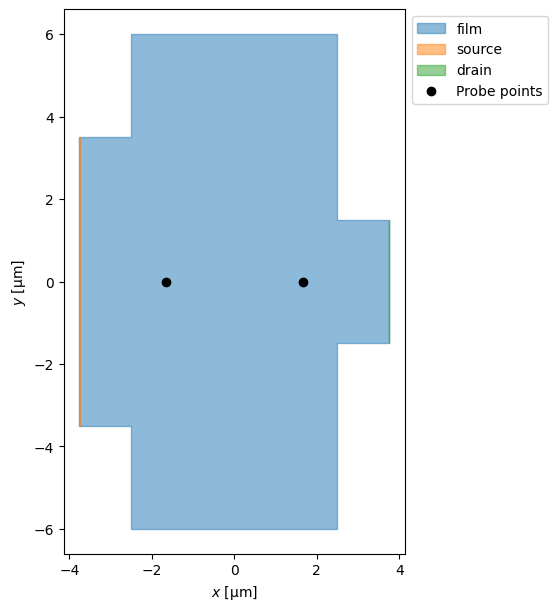

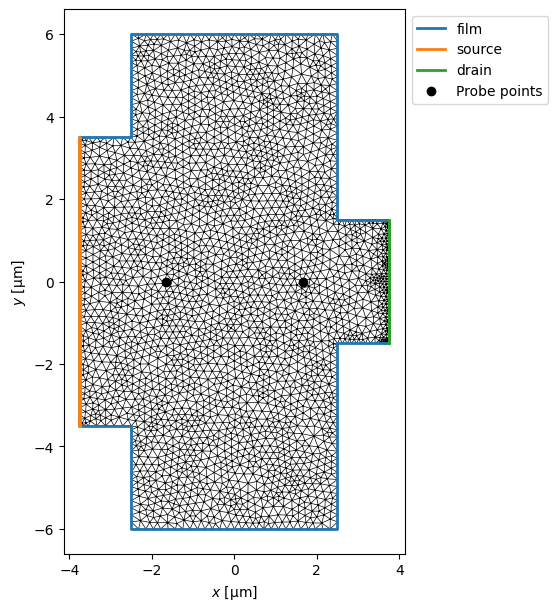

In [5]:
displacement = (width_x + width_x2 + STRIPE_LENGTH) / 2
device_fast = df.create_device(film_poly,half_geometry,layer,MAX_EDGE_LENGTH_IV,dimensions,translationx=displacement)
fig, ax = device_fast.plot(mesh=True)

# Simulations

## 1) Zero field for a fixed current

In [6]:
zero_field_solution = df.default_solution(device_fast,"zero_field_zero_current.h5",terminal_currents_applied=[28,-28])

Simulating: 100%|█████████████████████████████████████████████████████████████████▉| 200/200 [00:42<00:00,  4.67tau/s ]


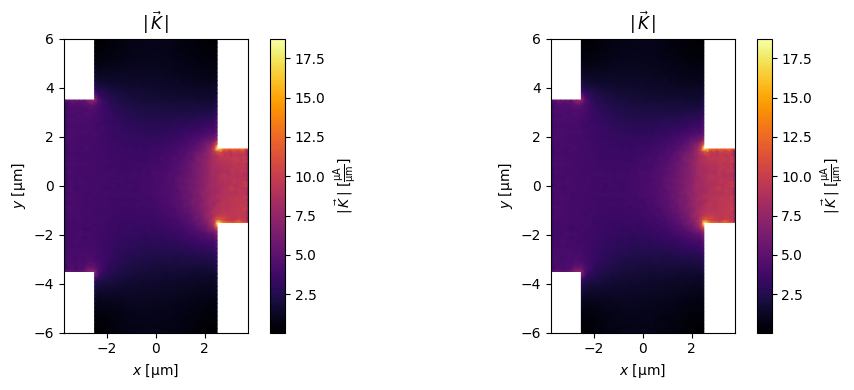

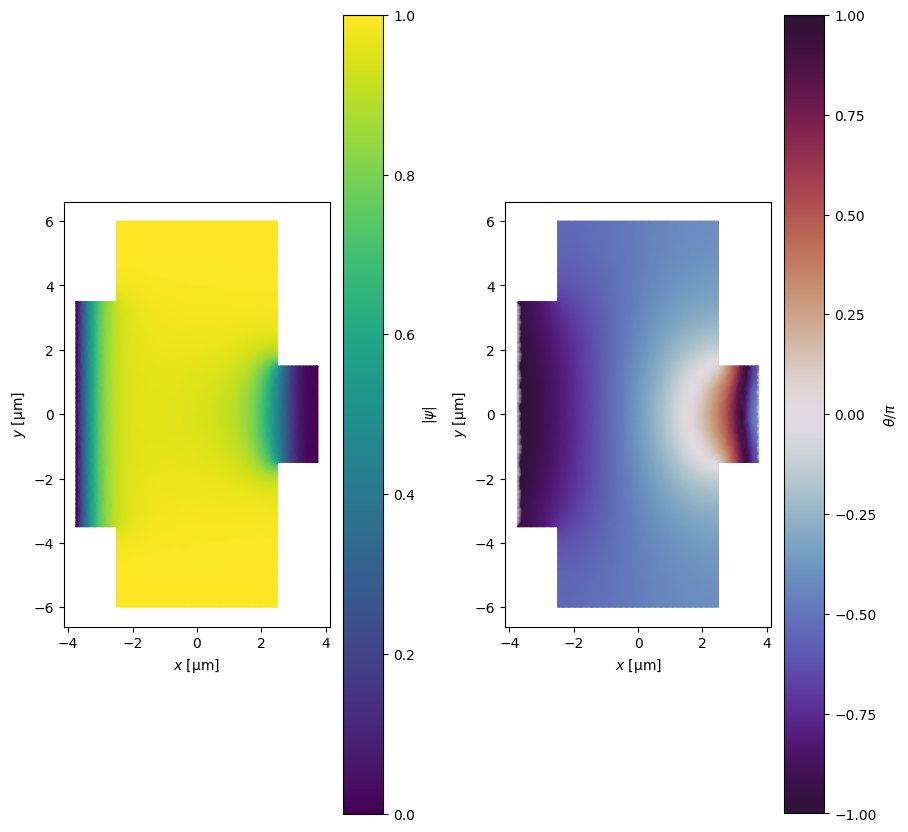

In [7]:
# Create figure with adjusted spacing
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Wider figure (10 inches width)
plt.subplots_adjust(wspace=0.4)  # Increase horizontal space between subplots
# Plot the currents
_ = zero_field_solution.plot_currents(ax=axes[0], streamplot=False)
_ = zero_field_solution.plot_currents(ax=axes[1])
# Evaluate sheet current density at cross-section
x = np.linspace(-width_x / 2, width_x / 2, 401)
y = 2 * np.ones_like(x)
cross_section = np.array([x, y]).T

plt.tight_layout()  # Automatically adjusts subplots to fit in figure
plt.show()
# Plot a snapshot of the order parameter in the middle of a phase slip
t0 = 155
zero_field_solution.solve_step = zero_field_solution.closest_solve_step(t0)
fig, axes = zero_field_solution.plot_order_parameter(figsize=(9, 10))
plt.show()

## 1.1)Constant Field for zero current

In [ ]:
zero_current_solution =  df.default_solution(device_fast, "weak-link-zero-field.h5",vector_potential=0.5)
fig, axes = zero_current_solution.plot_order_parameter(figsize=(5.5, 4))

Simulating:  79%|████████████████████████████████████████████████████▎             | 158/200 [00:41<00:12,  3.45tau/s ]

### 1.2)varying fields for zero current

In [ ]:
zero_current_solution_2 =  df.default_solution(device_fast, "weak-link-zero-field.h5",vector_potential=1)
fig, axes = zero_current_solution_2.plot_order_parameter(figsize=(5.5, 4))

In [ ]:
zero_current_solution_3 =  df.default_solution(device_fast, "weak-link-zero-field.h5",vector_potential=0.5)
fig, axes = zero_current_solution_3.plot_order_parameter(figsize=(5.5, 4))

In [ ]:
zero_current_solution_4 =  df.default_solution(device_fast, "weak-link-zero-field.h5",vector_potential=3)
fig, axes = zero_current_solution_4.plot_order_parameter(figsize=(5.5, 4))

In [ ]:
#if MAKE_ANIMATIONS:
#    zero_current_solution_video = df.make_video_from_solution(
#        zero_current_solution,
#        quantities=["order_parameter", "phase", "scalar_potential"],
#        figsize=(6.5, 4),
 
#    )
#    display(zero_current_solution_video)

### 1.3)Fixed field, zero current with varying increments 

In [ ]:
device_1 = df.create_device(film_poly,half_geometry,layer,MAX_EDGE_LENGTH_IV,dimensions,translationx=displacement,incrementy=1)#h = 4
zero_current_solution_1 =  df.default_solution(device_1, "weak-link-zero-field.h5",vector_potential=1)
fig, axes = zero_current_solution_1.plot_order_parameter(figsize=(5.5, 4))
plt.title(f'variación en y {1}')

In [ ]:
device_2 = df.create_device(film_poly,half_geometry,layer,MAX_EDGE_LENGTH_IV,dimensions,translationx=displacement,incrementy=2)#h = 5
zero_current_solution_2 =  df.default_solution(device_2, "weak-link-zero-field.h5",vector_potential=1)
fig, axes = zero_current_solution_2.plot_order_parameter(figsize=(5.5, 4))
plt.title(f'variación en y {2}')

In [ ]:
device_3 = df.create_device(film_poly,half_geometry,layer,MAX_EDGE_LENGTH_IV,dimensions,translationx=displacement,incrementy=4)#h = y
zero_current_solution_3 =  df.default_solution(device_3, "weak-link-zero-field.h5",vector_potential=1)
fig, axes = zero_current_solution_3.plot_order_parameter(figsize=(5.5, 4))
plt.title(f'variación en y {3}')

## 2)Magnetization

In [ ]:

# =========================
# 2) Applied field
# =========================
applied_field = np.linspace(0.0, 2, 10)  # External field on mT (B)
field_solutions,magnetization = df.solve_field(device_fast,applied_field)
plot_info = plot_labels={"fig_name":"currents.jpg","title":f'applied field vs magnetizations(0–1 mT)',"x":"B [$mT]","y":"magnetization"}
df.plot_parameters(applied_field, -magnetization,color_applied="red",plot_labels = plot_info)

## 3) Zero field with varying currents

Functions and currents

In [ ]:
co= 10
ci= 20 # current_interval
steps = 40
#currents = np.linspace(-ci, ci, steps)
currents = np.linspace(co, ci, steps)
# from -20 to 20 µA, step


#### 4.1) Simulation with the default device

In [ ]:
voltages = df.current_application(device_fast, currents,B_field = 1.0)


In [ ]:
actual_voltages = voltages 
plot_info1 = {"fig_name":"currents.jpg","title":f'Curva Voltaje vs Corriente (0–15 µA)',"x":"Corriente $I$ [$\mu$A]","y":"Voltaje promedio $\\langle \Delta \\mu \\rangle$ [$V_0$]"}
df.plot_parameters(currents,actual_voltages,plot_info1)

### 4.2) Zero field with varying currents and device modifications

In [ ]:
print(f'widths: width_x:{width_x},width_x2:{width_x2},height_y:{height_y},height_y2:{height_y2},height_y2_altered:{3}' )


In [ ]:
#height2 = de 4 a 7
io = 1
ifi = 4
size = ifi - io +1
voltages_arr = []
devices_arr = []
J = 0
def varying_increments():
    for h in range(io,ifi):      
        deltay = h
        if h == 3:
            deltay = 4
        device_l  = create_device(half_geometry,MAX_EDGE_LENGTH_IV,incrementy=deltay)
        voltages =  current_application(device_l, currents,B_field = 1.0)
        devices_arr.append(device_l)
        voltages_arr.append(voltages)
        J+= 1
        print(f'progress: {np.round((J/size)*100,3)}')

   

In [ ]:
for j in range(0,3):
    plot_info2 = {"fig_name":"currents.jpg","title":f'Curva Voltaje vs Corriente variación de x: {j} (0–15 µA)',"x":"Corriente $I$ [$\mu$A]","y":"Voltaje promedio $\\langle \Delta \\mu \\rangle$ [$V_0$]"}

    df.plot_parameters(currents,voltages_arr[j],plot_info2)

# Default functions
the primary functions to create new variations of the previous sections are:
 * create_device(geometry_used,max_edge_length,increment=3,translationx=((width_x + width_x2 + STRIPE_LENGTH) / 2),translationy=0)
 * current_application(device,currents)
 * plot_parameters(p1,voltages,plot_labels,plot_type="plot",color_applied="teal")